In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk

In [3]:
import sqlite3, json

In [4]:
RATIO = 0.618

### GET field names    

In [5]:
conn = sqlite3.connect('arxiv.db')
cursor = conn.cursor()

info = cursor.execute("PRAGMA TABLE_INFO(arxiv)")
field_names = [record[1] for record in info]
print(field_names)

cursor.close()
conn.close()

['abstract', 'authors', 'authors_parsed', 'categories', 'comments', 'doi', 'id', 'journal-ref', 'license', 'report-no', 'submitter', 'title', 'update_date', 'versions']


### SELECT categories and update_date from table

In [7]:
def get_date_and_cats():
    with sqlite3.connect('arxiv.db') as conn:
        cursor = conn.cursor()
        query = 'SELECT id, update_date, categories FROM arxiv ORDER BY update_date'
        query_result = cursor.execute(query)
        data = pd.DataFrame(query_result.fetchall())
        data.columns = ['id', 'update_date', 'categories']
        data = data.set_index(data.id).drop(columns=['id'])
        cursor.close()

    return data

In [8]:
data = get_date_and_cats()
data.head()

,update_date,categories
id,,
0704.0004,2007-05-23,math.CO
0704.0010,2007-05-23,math.CO
0704.0012,2007-05-23,math.NT
0704.0018,2007-05-23,hep-th
0704.0034,2007-05-23,q-bio.PE q-bio.CB quant-ph


In [9]:
data['year-month'] = data.update_date.str.extract(r'([0-9]+-[0-9]+)-[0-9]+')
data['year'] = data.update_date.str.extract(r'([0-9]+)-[0-9]+-[0-9]+')

In [10]:
year_groups = data.groupby('year').apply(len)
year_groups

year
2007    146648
2008     69535
2009    229386
2010     56492
2011     62190
2012     57709
2013     72579
2014     88881
2015    216670
2016    135461
2017    125866
2018    143191
2019    177383
2020    165316
dtype: int64

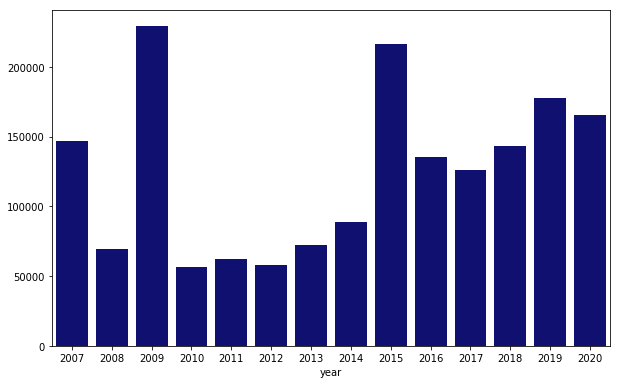

In [11]:
plt.figure(figsize=(10, 10*RATIO))
sns.barplot(x=year_groups.index, y=year_groups, color='navy')

### GROUP BY categories

In [14]:
data.categories.str.split(' ')

id
0704.0004                                                   [math.CO]
0704.0010                                                   [math.CO]
0704.0012                                                   [math.NT]
0704.0018                                                    [hep-th]
0704.0034                              [q-bio.PE, q-bio.CB, quant-ph]
0704.0037                           [physics.optics, physics.comp-ph]
0704.0049                                                   [math.CO]
0704.0050                                              [cs.NE, cs.AI]
0704.0052                                                    [hep-th]
0704.0061                                                   [math.FA]
0704.0066                                                    [hep-th]
0704.0071                                            [physics.soc-ph]
0704.0072                                          [math-ph, math.MP]
0704.0077                                            [physics.gen-ph]
0704.0079        